Importy bibliotek

In [238]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
import seaborn as sns
from sklearn.metrics import hamming_loss, f1_score

Wczytanie danych, przetwarzanie i inżynieria cech

In [239]:
FILE = 'data/stan_ustalony_gotowe.csv'

# Lista cech
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
]

# Urzadzenia 
# Usuniete phone_charger, usb_c_charger, decoder, lamp oraz hair_dryer
# Tymczasowe usuniecie induction_cooker, mixer, toaster, spin dryer, printer, baathroom_heater, sandwich_maker
DEVICE_COLUMNS = [
    'kettle', 
    'microwave', 
    'tv',
    'coffee_maker', 
    'immersion_heater',
    'aquarium_heater', 
    'heater',
    'laptop', 
    'christmas_tree', 
    'timer',
    'fridge', 
    'Monitor',
    #'sandwich_maker',
    'bathroom_heater', 
    'printer',
    'spin_dryer',
    #'toaster',
    'mixer',
    'induction_cooker',
    #'phone_charger', 
    #'usb_c_charger', 
    #'decoder', 
    #'hair_dryer'
]

# Wczytanie csv
df = pd.read_csv(FILE, sep=';', decimal=',')
df = df.iloc[:, :120]
# Usuwanie CAP/IND z Power Factor
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie powerfactor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Wiersze przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

Liczba wierszy przed czyszczeniem: 1316


In [243]:
# Zmienne dla nowych cech
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Sprawdzenie czy kolumny sa numeryczne
for col in [col_v, col_i, col_p, col_q]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Moc pozorna
df['S_total_calc'] = df[col_v] * df[col_i]

# Budeanu
# Wzór: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
df['Budeanu Distortion Power [VAr]'] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Fryze

# Konduktancja Czynna (Gw)
# Gw = P / U^2
df['Fryze_Conductance'] = df[col_p] / (df[col_v] ** 2)

# Prąd Czynny Fryzego (Iw)
# Wzór: Iw = Gw * U
df['Fryze_Active_Current'] = df['Fryze_Conductance'] * df[col_v]

# Prąd Bierny Fryzego (Ib)
# Wzór: Ib = sqrt(I_calkowite^2 - Iw^2)
df['Fryze_Passive_Current'] = np.sqrt(np.maximum(df[col_i]**2 - df['Fryze_Active_Current']**2, 0))

# Moc Bierna Fryzego (Pb)
# Wzór: Pb = sqrt(S^2 - P^2)
df['Fryze_Passive_Power'] = np.sqrt(np.maximum(df['S_total_calc']**2 - df[col_p]**2, 0))

# Nowe cechy
NEW_FEATURES = [
    'Budeanu Distortion Power [VAr]',
    'Fryze_Conductance',
    'Fryze_Active_Current',
    'Fryze_Passive_Current',
    'Fryze_Passive_Power'
]

In [244]:
# Dodanie nowych cech do juz istniejacych
for feature in NEW_FEATURES:
    if feature not in SELECTED_FEATURES:
        SELECTED_FEATURES.append(feature)
        print(f"-> Dodano nową cechę: {feature}")

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)


Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Budeanu Distortion Power [VAr]', 'Fryze_Conductance', 'Fryze_Active_Current', 'Fryze_Passive_Current', 'Fryze_Passive_Power']


In [250]:
# Usuniecie cech wynikajacych z teorii mocy
for feature in NEW_FEATURES:
    if feature in SELECTED_FEATURES:
        SELECTED_FEATURES.remove(feature)
        print(f"-> Usunieto ceche: {feature}")

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Usunieto ceche: Budeanu Distortion Power [VAr]
-> Usunieto ceche: Fryze_Conductance
-> Usunieto ceche: Fryze_Active_Current
-> Usunieto ceche: Fryze_Passive_Current
-> Usunieto ceche: Fryze_Passive_Power

Liczba cech: 6
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]']


In [251]:
# Zastapienie Inf/ -Inf na NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Zamiana NaN na 0
df[SELECTED_FEATURES] = df[SELECTED_FEATURES].fillna(0)

print(f"Wartości NaN/Inf zastąpiono zerami.")
print(f"Liczba wierszy: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Wydzielenie zbioru testowego
X_temp, y_temp, X_test, y_test = iterative_train_test_split(X, y, test_size=0.20)

# Wydzielenie zbioru walidacyjnego
X_train, y_train, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size=0.20)

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary Trening:   {X_train_scaled.shape}, y: {y_train.shape}")
print(f"Wymiary Walidacja: {X_val_scaled.shape}, y: {y_val.shape}")
print(f"Wymiary Test:      {X_test_scaled.shape}, y: {y_test.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Wartości NaN/Inf zastąpiono zerami.
Liczba wierszy: 1316
------------------------------
Wymiary Trening:   (841, 6), y: (841, 17)
Wymiary Walidacja: (211, 6), y: (211, 17)
Wymiary Test:      (264, 6), y: (264, 17)
Liczba cech: 6
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]']


In [252]:
# Sprawdzenie czy każde urządzenie ma reprezentację w każdym zbiorze
check_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train': y_train.sum(axis=0),
    'Val': y_val.sum(axis=0),
    'Test': y_test.sum(axis=0)
})
display(check_df.sort_values(by='Train', ascending=False))

,Device,Train,Val,Test
2,tv,414,104,130
10,fridge,251,63,78
7,laptop,182,46,57
3,coffee_maker,145,36,45
5,aquarium_heater,113,28,35
6,heater,113,30,36
8,christmas_tree,111,28,35
11,Monitor,98,24,31
12,bathroom_heater,84,23,27
9,timer,63,16,19


Analiza rozkładu klas (urządzeń) w zbiorach treningowych i testowych

In [253]:
# Zliczanie stanow ustalonych dla urzadzen
train_counts = y_train.sum(axis=0)
test_counts = y_test.sum(axis=0)
total_counts = train_counts + test_counts

# Podsumowanie
distribution_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train (1s)': train_counts,
    'Test (1s)': test_counts,
    'Total (1s)': total_counts,
    'Share [%]': (total_counts / len(df) * 100).round(2)
})

# Sortowanie malejąco wg liczby wystąpień
distribution_df.sort_values(by='Total (1s)', ascending=False, inplace=True)

print("Rozkład aktywności urządzeń:")
try:
    display(distribution_df)
except NameError:
    print(distribution_df)

Rozkład aktywności urządzeń:


,Device,Train (1s),Test (1s),Total (1s),Share [%]
2,tv,414,130,544,41.34
10,fridge,251,78,329,25.00
7,laptop,182,57,239,18.16
3,coffee_maker,145,45,190,14.44
6,heater,113,36,149,11.32
5,aquarium_heater,113,35,148,11.25
8,christmas_tree,111,35,146,11.09
11,Monitor,98,31,129,9.80
12,bathroom_heater,84,27,111,8.43
9,timer,63,19,82,6.23


In [228]:
def plot_multilabel_heatmap(y_true, y_pred, labels, title, cmap='viridis'):
    n_labels = len(labels)
    confusion_matrix = np.zeros((n_labels, n_labels))
    
    for i in range(n_labels):
        actual_present_mask = (y_true[:, i] == 1)
        if np.any(actual_present_mask):
            confusion_matrix[i, :] = y_pred[actual_present_mask, :].sum(axis=0)
    

    plt.figure(figsize=(14, 10))
    sns.heatmap(confusion_matrix, annot=False, fmt='.0f', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=16)
    plt.xlabel('Przewidziane urządzenia', fontsize=12)
    plt.ylabel('Faktycznie działające urządzenia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Random Forest

Koniec treningu Random Forest.
Exact Match (Subset Accuracy): 64.39%
F1-Score (Samples):            89.56%
F1-Score (Micro):              86.53%
Hamming Loss:                  0.0316
Raport klasyfikacji:
                  precision    recall  f1-score   support

          kettle       0.87      0.81      0.84        16
       microwave       1.00      1.00      1.00         8
              tv       0.90      0.78      0.84       130
    coffee_maker       0.97      0.78      0.86        45
immersion_heater       0.79      0.92      0.85        12
 aquarium_heater       0.97      1.00      0.99        35
          heater       0.85      0.81      0.83        36
          laptop       0.76      0.67      0.71        57
  christmas_tree       0.97      1.00      0.99        35
           timer       0.81      0.89      0.85        19
          fridge       0.91      0.94      0.92        78
         Monitor       0.81      0.84      0.83        31
 bathroom_heater       1.00      0.93    

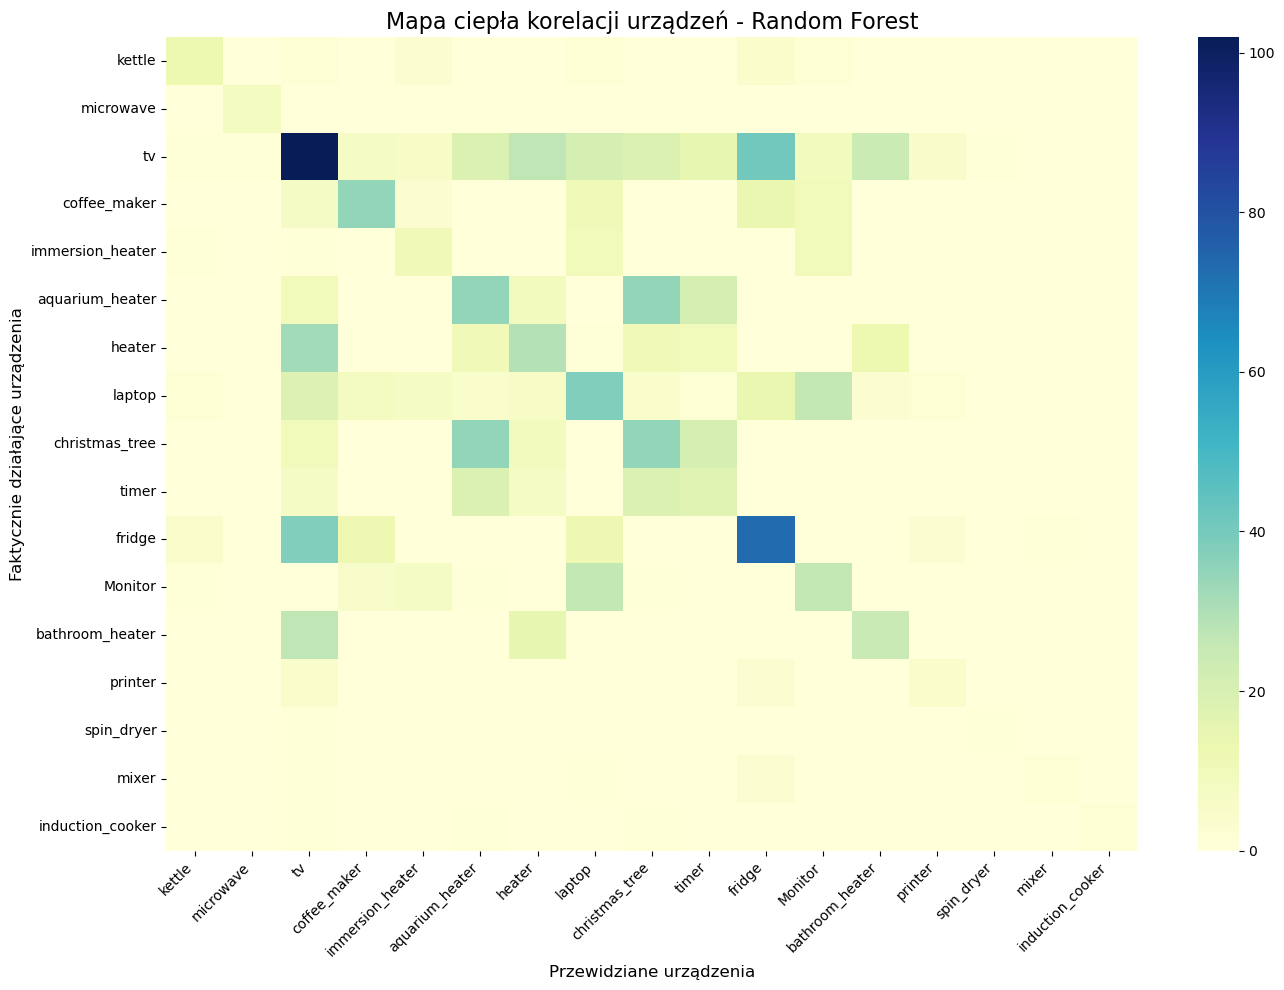

In [254]:
# Konfiguracja modelu
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model = RandomForestClassifier(
    n_estimators=320,        # większa liczba drzew
    max_depth=25,            # zmniejszona glebokosc
    min_samples_split=5,     # wezel musi miec min 5 probek do podzialu
    min_samples_leaf=2,      # lisc min 2 probki
    class_weight='balanced', # wieksze wagi dla mniejszościowych klas
    n_jobs=-1,               # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Dopasowanie modelu do danych treningowych
rf_model.fit(X_train_scaled, y_train)
print("Koniec treningu Random Forest.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

rf_hamming = hamming_loss(y_test, y_pred)
rf_f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=1)
rf_f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
rf_exact_match = accuracy_score(y_test, y_pred)
print(f"Exact Match (Subset Accuracy): {rf_exact_match:.2%}")
print(f"F1-Score (Samples):            {rf_f1_samples:.2%}")
print(f"F1-Score (Micro):              {rf_f1_micro:.2%}")
print(f"Hamming Loss:                  {rf_hamming:.4f}")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - Random Forest",
    cmap='YlGnBu'
)

Multi layer Perceptron (Neural Network) - TensorFlow/Keras

TensorFlow version: 2.10.0
Dostępne urządzenia: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 64)                448       
                                                                 
 dropout_116 (Dropout)       (None, 64)                0         
                                                                 
 dense_175 (Dense)           (None, 32)                2080      
                                                                 
 dropout_117 (Dropout)       (None, 32)                0         
                                                                 
 dense_176 (Dense)           (None, 17)                561       
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
__

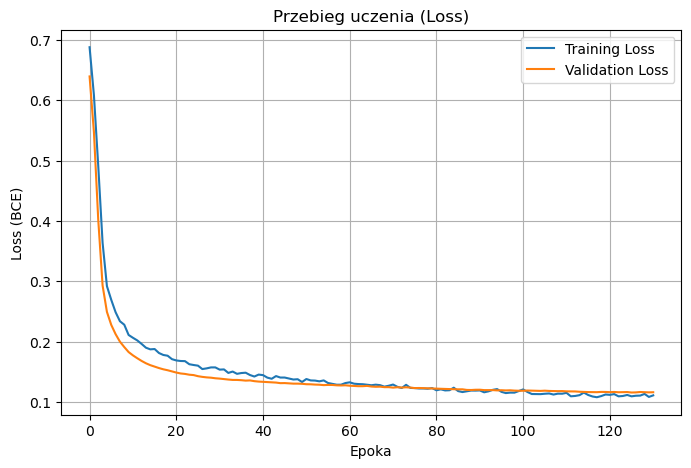

9/9 [==============================] - 0s 2ms/step
Exact Match (Subset Accuracy): 51.52%
F1-Score (Samples):            85.25%
F1-Score (Micro):              80.79%
Hamming Loss:                  0.0434
Szczegółowy raport klasyfikacji:
                  precision    recall  f1-score   support

          kettle       0.92      0.75      0.83        16
       microwave       1.00      1.00      1.00         8
              tv       0.88      0.72      0.79       130
    coffee_maker       0.89      0.71      0.79        45
immersion_heater       0.75      1.00      0.86        12
 aquarium_heater       1.00      1.00      1.00        35
          heater       0.96      0.72      0.83        36
          laptop       0.67      0.42      0.52        57
  christmas_tree       1.00      1.00      1.00        35
           timer       0.74      0.74      0.74        19
          fridge       0.77      0.87      0.82        78
         Monitor       0.96      0.81      0.88        31
 bathroom

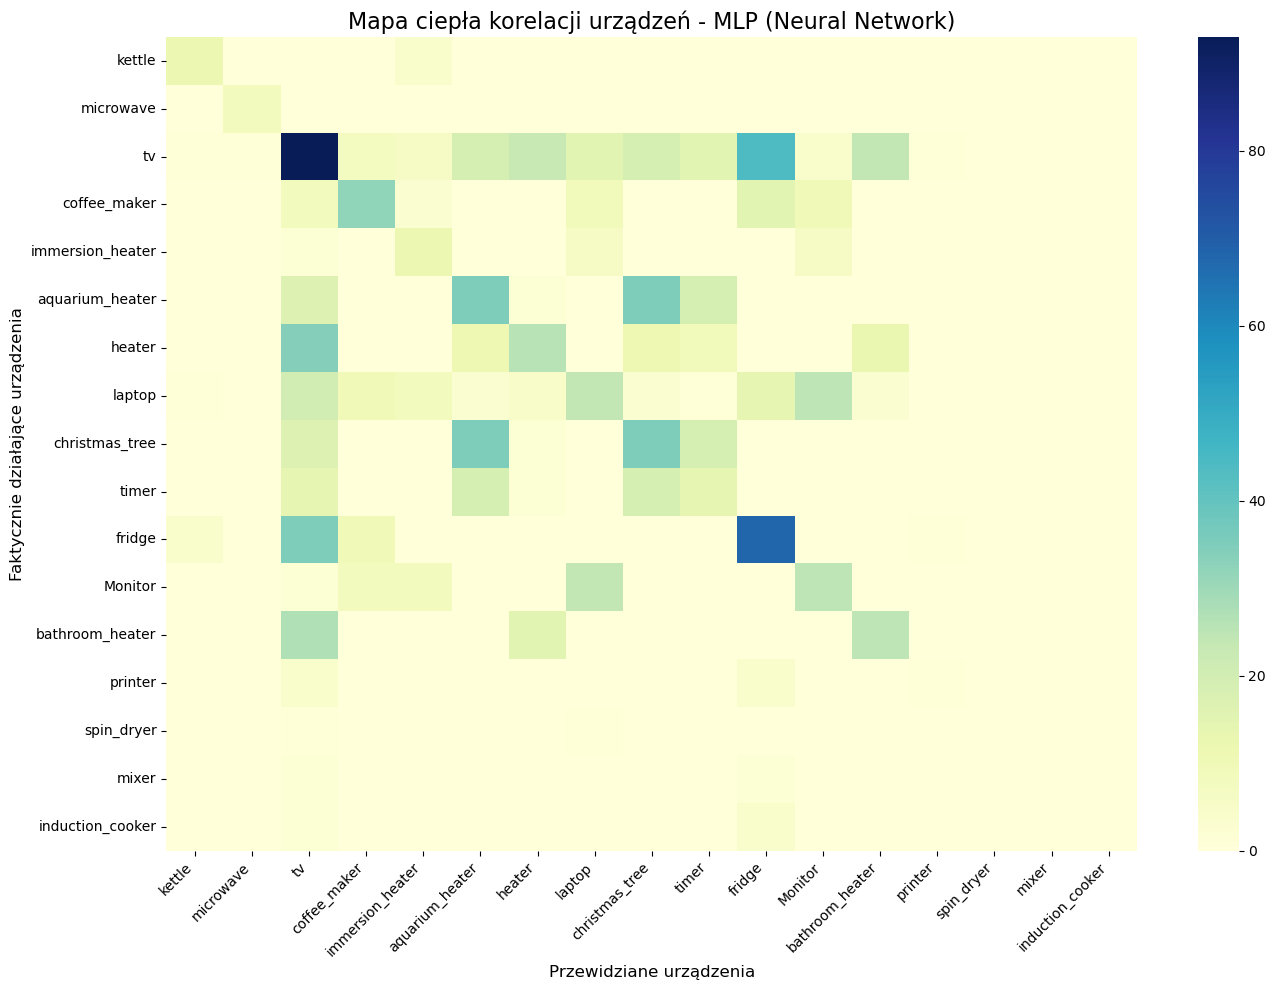

In [258]:
# Sprawdzenie dostępności GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3), 
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    # Warstwa wyjściowa
    layers.Dense(output_dim)
])

# Wyświetlenie podsumowania architektury
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

EPOCHS = 150
BATCH_SIZE = 32

print("Rozpoczynam trening sieci neuronowej (TensorFlow)...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Wykres funkcji straty
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()

# Predykcja zwraca "logits" (surowe wartości)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
from sklearn.metrics import accuracy_score, classification_report
acc_dnn = accuracy_score(y_test, y_pred_numpy)

mlp_exact_match = accuracy_score(y_test, y_pred_numpy)
mlp_f1_samples = f1_score(y_test, y_pred_numpy, average='samples', zero_division=1)
mlp_f1_micro = f1_score(y_test, y_pred_numpy, average='micro', zero_division=1)
mlp_hamming = hamming_loss(y_test, y_pred_numpy)

print(f"Exact Match (Subset Accuracy): {mlp_exact_match:.2%}")
print(f"F1-Score (Samples):            {mlp_f1_samples:.2%}")
print(f"F1-Score (Micro):              {mlp_f1_micro:.2%}")
print(f"Hamming Loss:                  {mlp_hamming:.4f}")

print("Szczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))

plot_multilabel_heatmap(
    y_test, 
    y_pred_numpy, 
    DEVICE_COLUMNS, 
    "Mapa ciepła korelacji urządzeń - MLP (Neural Network)",
    cmap='YlGnBu'
)